In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
from mlxtend.plotting import plot_confusion_matrix
from dataset import dataloader

# 1. Prepare the training and test datasets(MNIST)

In [2]:
batch_size = 100
epsilone = 0.000001
learning_rate = 0.001
epochs = 100

In [3]:
train = dataloader.Dataloader("dataset", is_train = True, shuffle = True, batch_size = batch_size)
test = dataloader.Dataloader("dataset", is_train = False, shuffle = True, batch_size = batch_size)

In [4]:
# min-max normalization
def norm(x):
    return (x-np.min(x))/(np.max(x) - np.min(x))

# 2. Build a 3-layer Neural Network

### 1) Implement a sub-modules (Linear layer, ReLU)

In [5]:
class Linear():
    def __init__(self, learning_rate, in_num, out_num):
        self.learning_rate = learning_rate
        self.weight = 1/np.sqrt(in_num)*np.random.randn(in_num,out_num)
        self.bias = 1/np.sqrt(in_num)*np.random.randn(out_num)
        self.x = None
        
    def forward(self, x):
        self.x = x
        return np.dot(x,self.weight)+self.bias
    
    def backward(self, output_gradient):
        input_gradient = np.dot(output_gradient, np.transpose(self.weight))
        weight_gradient = np.dot(np.transpose(self.x), output_gradient)
        
        self.weight = self.weight - self.learning_rate*weight_gradient
        self.bias = self.bias - np.sum(output_gradient,axis =0)*self.learning_rate
        
        return input_gradient

In [6]:
class ReLU():
    def __init__(self):
        self.x = None
    
    def length(self,x):
        return len(x)
    
    def forward(self,x):
        self.x = x
        return np.maximum(0,x)
    
    def backward(self,output_gradient):
        return (self.x>0)*output_gradient

### 2) Implement functions (Softmax, CE loss)

In [7]:
class Softmax_CE_loss():        
    def __init__(self):
        self.x = None
        self.t = None
        self.batch_size = None
        
    def forward(self,x,t):
        self.x = x
        self.t = t
        #overflow 방지
        x_wo_of = self.x - np.max(self.x)
        output = np.exp(x_wo_of)/np.sum(np.exp(x_wo_of))
        self.batch_size = output.shape[0]
        loss = (np.sum(-1*self.t*np.log(output+epsilone)))/output.shape[0]
        return loss
    
    def prob(self,x):
        a= np.exp(5*x)/(np.array([np.sum(np.exp(5*x),axis =-1)]*x.shape[-1]).T)
        return a
    
    def backward(self):
        output = (self.x - self.t)/self.batch_size
        return output

### 3) Build a 3-layer NN

Sequence : Input - Linear - ReLU - Linear - ReLU - Linear - SoftMax

input size : 28X28, output size : 10

In [8]:
class NN():
    def __init__(self, learning_rate):
        self.inputs = [0]*6
        self.learning_rate = learning_rate
        self.input = None
        self.gt = None
        self.linear1 = Linear(self.learning_rate,784, 196)
        self.ReLU1 = ReLU()
        self.linear2 = Linear(self.learning_rate,196, 49)
        self.ReLU2 = ReLU()
        self.linear3 = Linear(self.learning_rate,49, 10)
        self.softmax_ce_loss = Softmax_CE_loss()
        
    def forward(self,x,y):
        self.input = x
        self.gt = y
        self.inputs[0] = self.linear1.forward(self.input)
        self.inputs[1] = self.ReLU1.forward(self.inputs[0])
        self.inputs[2] = self.linear2.forward(self.inputs[1])
        self.inputs[3] = self.ReLU2.forward(self.inputs[2])
        self.inputs[4] = self.linear3.forward(self.inputs[3])
        return self.inputs[4]

    def backward(self):
        output_gradient = self.softmax_ce_loss.backward()
        output_gradient = self.linear3.backward(output_gradient)
        output_gradient = self.ReLU2.backward(output_gradient)
        output_gradient = self.linear2.backward(output_gradient)
        output_gradient = self.ReLU1.backward(output_gradient)
        output_gradient = self.linear1.backward(output_gradient)
        return output_gradient
    
    def train(self,x,y):
        output = self.softmax_ce_loss.forward(self.forward(x,y),self.gt)
    
    def test(self,x,y):
        return np.sum(np.argmax(y, axis = -1)==np.argmax(self.forward(x,y), axis = -1))
        
    def confuse(self,x,y):
        return np.argmax(self.forward(x,y),axis=-1),np.argmax(y,axis=-1)
    
    def top3(self,x,y):
        out = self.softmax_ce_loss.prob(self.forward(x,y))
        return np.argmax(out), np.max(out)
        
    def loss(self,x,y):
        output = self.softmax_ce_loss.forward(self.forward(x,y),self.gt)
        return output

# 3. Implement training pipeline & train NN

In [9]:
train_loss = []
test_loss = []

def NN_training(NN):
    for i, train_data in enumerate(train):
        if i+1 == train.__len__():
            train_loss.append(NN.loss(norm(train_data[:][0].reshape(batch_size,784)),norm(train_data[:][1])))
        NN.train(norm(train_data[:][0].reshape(batch_size,784)),norm(train_data[:][1]))
        NN.backward()
        
def NN_test(NN):
    correct = 0
    for i, test_data in enumerate(test):
        if i+1 == test.__len__():
            test_loss.append(NN.loss(norm(test_data[:][0].reshape(batch_size,784)),norm(test_data[:][1])))
        correct += NN.test(norm(test_data[:][0].reshape(batch_size,784)),norm(test_data[:][1]))
    return correct / (test.__len__()*batch_size)

In [10]:
NN = NN(learning_rate)

for i in range(100):
    NN_training(NN)
    print(i+1,'Epoch Finished', end = '\t')
    print(f"Accuracy : {round(100*NN_test(NN),2)}%")

1 Epoch Finished	Accuracy : 32.44%
2 Epoch Finished	Accuracy : 52.71%
3 Epoch Finished	Accuracy : 63.41%
4 Epoch Finished	Accuracy : 70.3%
5 Epoch Finished	Accuracy : 74.68%
6 Epoch Finished	Accuracy : 77.9%
7 Epoch Finished	Accuracy : 80.3%
8 Epoch Finished	Accuracy : 81.9%
9 Epoch Finished	Accuracy : 83.07%
10 Epoch Finished	Accuracy : 84.14%
11 Epoch Finished	Accuracy : 84.94%
12 Epoch Finished	Accuracy : 85.62%
13 Epoch Finished	Accuracy : 86.13%
14 Epoch Finished	Accuracy : 86.61%
15 Epoch Finished	Accuracy : 87.1%
16 Epoch Finished	Accuracy : 87.61%
17 Epoch Finished	Accuracy : 87.92%
18 Epoch Finished	Accuracy : 88.19%
19 Epoch Finished	Accuracy : 88.53%
20 Epoch Finished	Accuracy : 88.72%
21 Epoch Finished	Accuracy : 88.9%
22 Epoch Finished	Accuracy : 89.1%
23 Epoch Finished	Accuracy : 89.3%
24 Epoch Finished	Accuracy : 89.4%
25 Epoch Finished	Accuracy : 89.55%
26 Epoch Finished	Accuracy : 89.7%
27 Epoch Finished	Accuracy : 89.97%
28 Epoch Finished	Accuracy : 90.09%
29 Epoch Fi

# 4. Test the 3-layer NN, draw figures

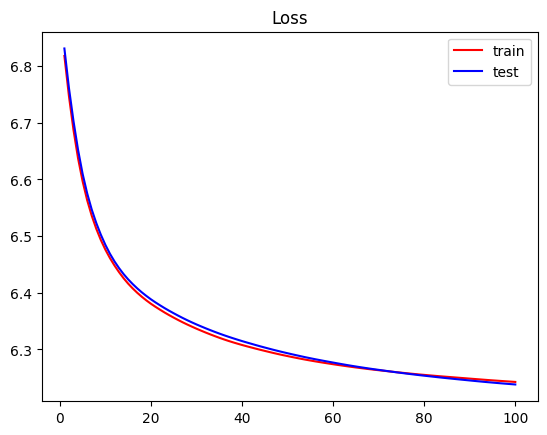

In [11]:
x = np.arange(1,101)
plt.plot(x,train_loss,'r', label="train")
plt.plot(x,test_loss,'b', label = "test")
plt.title("Loss")
plt.legend(loc = 'upper right')
plt.show()

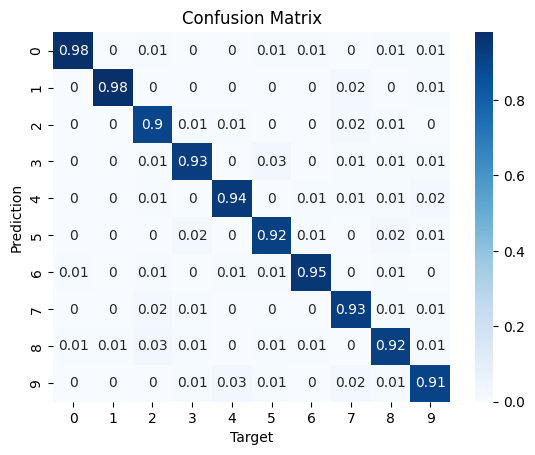

In [12]:
confuse_matrix = np.zeros((10,10))
target_num = [0]*10
length = test.__len__()
for i in range(length):
    for j in range(batch_size):
        c_train, c_test = NN.confuse(test.__getitem__(i)[0][j].reshape(1,784),test.__getitem__(i)[1][j])
        confuse_matrix[c_train,c_test] += 1
        target_num[c_test] +=1
        
for i in range(10):
    confuse_matrix[:,i] = np.round_(np.divide(confuse_matrix[:,i],target_num[i]),2)
    
sns.heatmap(confuse_matrix, cmap = "Blues", annot = True)
plt.title("Confusion Matrix")
plt.ylabel("Prediction")
plt.xlabel("Target")
plt.show()

In [13]:
pred_num = []
for i in range(10):
    pred_num.append([0])
    pred_num[i].remove(0)
length = test.__len__()
for i in range(length):
    for j in range(batch_size):
        idx, val = NN.top3(test.__getitem__(i)[0][j].reshape(1,784),test.__getitem__(i)[1][j])
        pred_num[idx].append([val,i,j])
        
for i in range(len(target_num)):
    pred_num[i].sort(reverse = True)
    
print(pred_num[0][0])

[0.9914200710020913, 50, 77]


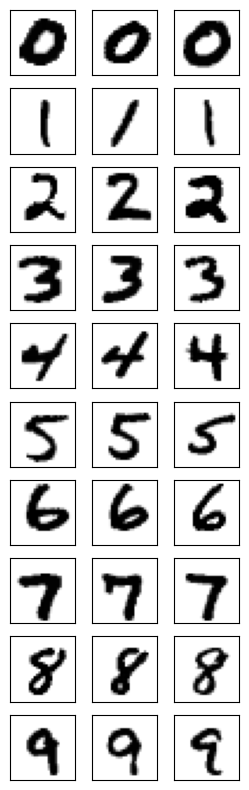

In [14]:
plt.figure(figsize = (3,10))
for i in range(10):
    for j in range(3):
        plt.subplot(10,3,i*3+j+1)
        plt.imshow(test.__getitem__(pred_num[i][j][1])[0][pred_num[i][j][2]].reshape(28,28), cmap=cm.binary)
        plt.gca().axes.xaxis.set_visible(False)
        plt.gca().axes.yaxis.set_visible(False)

In [15]:
for i in range(10):
    print(i,": ",end='')
    for j in range(3):
        print(f"{round(100*pred_num[i][j][0],2)}%",end="    ")
    print()
    print()

0 : 99.14%    99.14%    98.97%    

1 : 98.25%    97.85%    97.7%    

2 : 99.57%    99.48%    99.47%    

3 : 99.61%    99.41%    99.35%    

4 : 99.76%    99.5%    99.4%    

5 : 99.18%    99.15%    98.99%    

6 : 99.27%    99.27%    99.21%    

7 : 99.21%    99.12%    99.04%    

8 : 99.03%    98.92%    98.87%    

9 : 99.39%    99.17%    98.84%    



# 5. Build a CNN by replacing Linear layer to Conv layer

### 1) Design a sub-modules & their backpropagation

In [16]:
def im2col(input_data, filter_h, filter_w, stride=1, pad=0):
    N, C, H, W = input_data.shape
    out_h = (H + 2*pad - filter_h)//stride + 1
    out_w = (W + 2*pad - filter_w)//stride + 1

    img = np.pad(input_data, [(0,0), (0,0), (pad, pad), (pad, pad)], 'constant')
    col = np.zeros((N, C, filter_h, filter_w, out_h, out_w))

    for y in range(filter_h):
        y_max = y + stride*out_h
        for x in range(filter_w):
            x_max = x + stride*out_w
            col[:, :, y, x, :, :] = img[:, :, y:y_max:stride, x:x_max:stride]

    col = col.transpose(0, 4, 5, 1, 2, 3).reshape(N*out_h*out_w, -1)
    return col

In [17]:
def col2im(col, input_shape, filter_h, filter_w, stride=1, pad=0):    
    N, C, H, W = input_shape
    out_h = (H + 2*pad - filter_h) // stride + 1
    out_w = (W + 2*pad - filter_w) // stride + 1
    col = col.reshape(N, out_h, out_w, C, filter_h, filter_w).transpose(0, 3, 4, 5, 1, 2)
    
    img = np.zeros((N, C, H + 2*pad + stride - 1, W + 2*pad + stride - 1))
    for y in range(filter_h):
        y_max = y + stride*out_h
        for x in range(filter_w):
            x_max = x + stride*out_w
            img[:, :, y:y_max:stride, x:x_max:stride] += col[:, :, y, x, :, :]
            
    return img[:, :, pad:H + pad, pad:W + pad]

In [18]:
class convolution():
    def __init__(self, learning_rate, in_channels, size, out_channels, kernel_size, batch_size = 100, stride = 1, padding = 0):
        self.learning_rate = learning_rate
        self.kernel_size = kernel_size
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.batch_size = batch_size
        self.width = size
        self.height = size
        self.stride = stride
        self.padding = padding
        self.t = None
        self.x = None
        self.col = None
        self.out_shape = None
        self.weight = (np.sqrt(2/(self.in_channels*self.width*self.height + self.out_channels*self.width*self.height))*np.random.randn(self.out_channels,self.in_channels,self.kernel_size,self.kernel_size))
        self.bias = (np.sqrt(2/(self.in_channels*self.width*self.height + self.out_channels*self.width*self.height))*np.random.randn(self.batch_size, self.out_channels,self.width,self.height)).reshape(self.width*self.height*self.batch_size,self.out_channels)
        
    def forward(self,x):
        self.x = x
        FN, C, FH, FW = self.weight.shape
        N, C, H, W = x.shape
        self.out_shape = int(1+(self.x.shape[-1]-self.kernel_size+2*self.padding)/self.stride)
        col = im2col(self.x,FH, FW, self.stride, self.padding)
        col_W = self.weight.reshape(FN,-1).T
        
        self.col = col
        self.col_W = col_W
        dot_result = np.dot(col,col_W)+self.bias
        dot_result = dot_result.reshape(N, self.out_shape, self.out_shape, -1).transpose(0,3,1,2)
        
        return dot_result
    
    def backward(self, output_gradient):
        FN, C, FH, FW = self.weight.shape
        self.output_gradient = output_gradient.transpose(0,2,3,1).reshape(-1,FN)
        
        self.db = np.sum(self.output_gradient,axis = 0)
        weight_gradient = np.dot(self.col.T,self.output_gradient)
        weight_gradient = weight_gradient.transpose(1,0).reshape(FN,C,FH, FW)
        
        out = np.dot(self.output_gradient, self.col_W.T)
        
        out = col2im(out, self.x.shape, FH, FW, self.stride, self.padding)
        
        self.weight -= self.learning_rate*weight_gradient
        
        return out

In [19]:
class MaxPooling():
    def __init__(self,kernel_size, stride = 1, padding = 0, batch_size = 100):
        self.x = None
        self.batch_size = batch_size
        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = padding
        self.in_channels = None
        self.out_shape = None
        self.argmax_result = None
        self.t = None
        
    def forward(self,x):
        self.x = x
        N, C, H, W = x.shape
        self.out_shape = int(1+(self.x.shape[-1]-self.kernel_size+2*self.padding)/self.stride)
        
        col = im2col(self.x,self.kernel_size, self.kernel_size, self.stride,self.padding).reshape(-1,self.kernel_size**2)
        
        argmax_result = np.argmax(col, axis = 1)
        
        max_result = np.max(col, axis=1)
        max_result = max_result.reshape(N, self.out_shape, self.out_shape, C).transpose(0,3,1,2)
        
        self.argmax_result = argmax_result.flatten()
        
        return max_result
    
    def backward(self, output_gradient):
        output_gradient = output_gradient.transpose(0,2,3,1) 
        
        zero = np.zeros((output_gradient.size, self.kernel_size**2))
        zero[np.arange(self.argmax_result.size), self.argmax_result.flatten()] = output_gradient.flatten()
        
        zero = zero.reshape(output_gradient.shape +(self.kernel_size**2,))
        zero = zero.reshape(zero.shape[0]*zero.shape[1]*zero.shape[2],-1)
        
        img = col2im(zero,self.x.shape,self.kernel_size, self.kernel_size, self.stride, self.padding)
        
        return img

In [20]:
class Linear_for_conv():
    def __init__(self, learning_rate, in_num, out_num):
        self.learning_rate = learning_rate
        self.weight = 1/np.sqrt(in_num)*np.random.randn(in_num,out_num)
        self.bias = 1/np.sqrt(in_num)*np.random.randn(out_num)
        self.x = None
        self.x_size = None
        
    def forward(self, x):
        self.x_shape = x.shape
        self.x = x.reshape(x.shape[0],-1)
        return np.dot(self.x,self.weight)+self.bias
    
    def backward(self, output_gradient):
        input_gradient = np.dot(output_gradient, np.transpose(self.weight)).reshape(self.x_shape) # 한번더 확인
        weight_gradient = np.dot(np.transpose(self.x), output_gradient)
        
        self.weight = self.weight - self.learning_rate*weight_gradient
        
        return input_gradient

### 2) Design CNN

In [21]:
class CNN():
    def __init__(self, learning_rate):
        self.inputs = [0]*7
        self.learning_rate = learning_rate
        self.input = None
        self.gt = None
        self.maxPool1 = MaxPooling(kernel_size=2, stride=2, padding = 0, batch_size=batch_size)
        self.maxPool2 = MaxPooling(kernel_size=2, stride=2, padding = 0, batch_size=batch_size)
        self.conv1 = convolution(self.learning_rate, in_channels = 1, size = 28, out_channels = 2, kernel_size = 3, stride = 1, padding = 1, batch_size = batch_size)
        self.ReLU1 = ReLU()
        self.conv2 = convolution(self.learning_rate, in_channels = 2, size = 14, out_channels = 4, kernel_size = 3, stride = 1, padding = 1, batch_size = batch_size)
        self.ReLU2 = ReLU()
        self.linear = Linear_for_conv(self.learning_rate,49*4, 10)
        self.softmax_ce_loss = Softmax_CE_loss()
        
    def forward(self,x,y):
        self.input = x
        self.gt = y
        self.inputs[0] = self.conv1.forward(self.input)
        self.inputs[1] = self.ReLU1.forward(self.inputs[0])
        self.inputs[2] = self.maxPool1.forward(self.inputs[1])
        self.inputs[3] = self.conv2.forward(self.inputs[2])
        self.inputs[4] = self.ReLU2.forward(self.inputs[3])
        self.inputs[5] = self.maxPool2.forward(self.inputs[4])
        self.inputs[6] = self.linear.forward(self.inputs[5])
        return self.inputs[6]
        
    def backward(self):
        output_gradient = self.softmax_ce_loss.backward()
        output_gradient = self.linear.backward(output_gradient)
        output_gradient = self.maxPool2.backward(output_gradient)
        output_gradient = self.ReLU2.backward(output_gradient)
        output_gradient = self.conv2.backward(output_gradient)
        output_gradient = self.maxPool1.backward(output_gradient)
        output_gradient = self.ReLU1.backward(output_gradient)
        output_gradient = self.conv1.backward(output_gradient)
        return output_gradient
    
    def train(self,x,y):
        output = self.softmax_ce_loss.forward(self.forward(x,y),self.gt)
        return output
    
    def test(self,x,y):
        return np.sum(np.argmax(y, axis = -1)==np.argmax(self.forward(x,y), axis = -1))
    
    def confuse(self,x,y):
        return np.argmax(self.forward(x,y),axis=-1),np.argmax(y,axis=-1)
    
    def top3(self,x,y):
        out = self.softmax_ce_loss.prob(self.forward(x,y))
        return np.argmax(out, axis=-1), np.max(out, axis = -1)
        
    def loss(self,x,y):
        output = self.softmax_ce_loss.forward(self.forward(x,y),self.gt)
        return output

### 3) Train CNN

In [22]:
cnn_train_loss = []
cnn_test_loss = []

def CNN_training(CNN):
    for i, train_data in enumerate(train):
        if i+1 == train.__len__():
            cnn_train_loss.append(CNN.loss(norm(train_data[:][0].reshape(batch_size,1,28,28)),norm(train_data[:][1])))
        CNN.train(norm(train_data[:][0].reshape(batch_size,1,28,28)),norm(train_data[:][1]))
        CNN.backward()
        
def CNN_test(CNN):
    correct = 0
    for i, test_data in enumerate(test):
        if i+1 == test.__len__():
            cnn_test_loss.append(CNN.loss(norm(test_data[:][0].reshape(batch_size,1,28,28)),norm(test_data[:][1])))
        correct += CNN.test(norm(test_data[:][0].reshape(batch_size,1,28,28)),norm(test_data[:][1]))
    return correct / (test.__len__()*batch_size)

In [23]:
learning_rate = 0.01
CNN = CNN(learning_rate)

for i in range(100):
    CNN_training(CNN)
    print(i+1,'Epoch Finished', end = '\t')
    print(f"Accuracy : {round(100*CNN_test(CNN),2)}%")

1 Epoch Finished	Accuracy : 15.43%
2 Epoch Finished	Accuracy : 62.84%
3 Epoch Finished	Accuracy : 79.03%
4 Epoch Finished	Accuracy : 82.67%
5 Epoch Finished	Accuracy : 84.53%
6 Epoch Finished	Accuracy : 85.76%
7 Epoch Finished	Accuracy : 86.77%
8 Epoch Finished	Accuracy : 87.65%
9 Epoch Finished	Accuracy : 88.43%
10 Epoch Finished	Accuracy : 89.1%
11 Epoch Finished	Accuracy : 89.68%
12 Epoch Finished	Accuracy : 90.19%
13 Epoch Finished	Accuracy : 90.61%
14 Epoch Finished	Accuracy : 90.88%
15 Epoch Finished	Accuracy : 91.34%
16 Epoch Finished	Accuracy : 91.79%
17 Epoch Finished	Accuracy : 91.93%
18 Epoch Finished	Accuracy : 92.11%
19 Epoch Finished	Accuracy : 92.29%
20 Epoch Finished	Accuracy : 92.47%
21 Epoch Finished	Accuracy : 92.62%
22 Epoch Finished	Accuracy : 92.68%
23 Epoch Finished	Accuracy : 92.75%
24 Epoch Finished	Accuracy : 92.86%
25 Epoch Finished	Accuracy : 92.97%
26 Epoch Finished	Accuracy : 93.09%
27 Epoch Finished	Accuracy : 93.12%
28 Epoch Finished	Accuracy : 93.18%
29

# 6. Test the CNN, draw figures

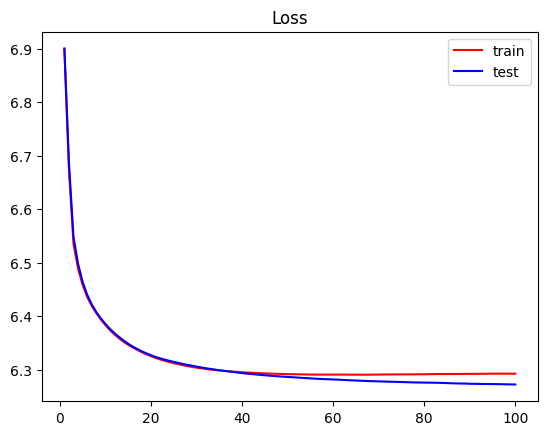

In [29]:
x = np.arange(1,101)
plt.plot(x,cnn_train_loss,'r', label="train")
plt.plot(x,cnn_test_loss,'b', label = "test")
plt.title("Loss")
plt.legend(loc = 'upper right')
plt.show()

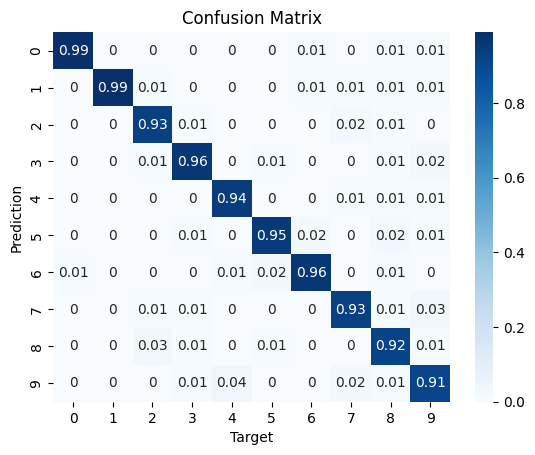

In [30]:
confuse_matrix = np.zeros((10,10))
target_num = [0]*10
length = test.__len__()
for i, test_data in enumerate(test):
    c_train, c_test = CNN.confuse(norm(test_data[:][0].reshape(batch_size,1,28,28)),norm(test_data[:][1]))
    for j in range(len(c_train)):
        confuse_matrix[c_train[j],c_test[j]] += 1
        target_num[c_test[j]] +=1
        
for i in range(10):
    confuse_matrix[:,i] = np.round_(np.divide(confuse_matrix[:,i],target_num[i]),2)
    
sns.heatmap(confuse_matrix, cmap = "Blues", annot = True)
plt.title("Confusion Matrix")
plt.ylabel("Prediction")
plt.xlabel("Target")
plt.show()

In [31]:
cnn_pred_num = []
for i in range(10):
    cnn_pred_num.append([0])
    cnn_pred_num[i].remove(0)
length = test.__len__()//batch_size
for i,test_data in enumerate(test):
    idx, val = CNN.top3(norm(test_data[:][0].reshape(batch_size,1,28,28)),norm(test_data[:][1]))
    for j in range(test.__len__()):
        cnn_pred_num[idx[j]].append([val[j],i,j])
        
for i in range(len(target_num)):
    cnn_pred_num[i].sort(reverse = True)
    
print(cnn_pred_num[0][0])

[0.9854908568212376, 67, 11]


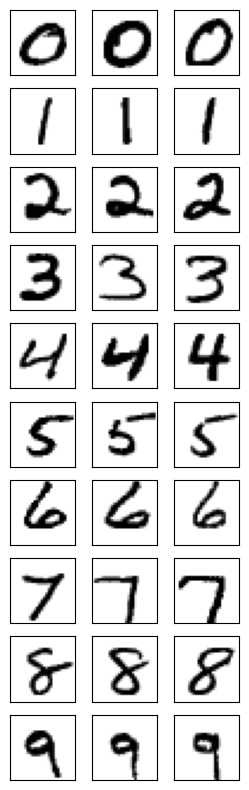

In [32]:
plt.figure(figsize = (3,10))
for i in range(10):
    for j in range(3):
        plt.subplot(10,3,i*3+j+1)
        plt.imshow(test.__getitem__(cnn_pred_num[i][j][1])[0][cnn_pred_num[i][j][2]].reshape(28,28), cmap=cm.binary)
        plt.gca().axes.xaxis.set_visible(False)
        plt.gca().axes.yaxis.set_visible(False)

In [33]:
for i in range(10):
    print(i,": ",end='')
    for j in range(3):
        print(f"{round(100*cnn_pred_num[i][j][0],2)}%",end="    ")
    print()
    print()

0 : 98.55%    98.43%    98.31%    

1 : 96.57%    96.51%    96.34%    

2 : 99.49%    99.46%    99.41%    

3 : 98.2%    97.51%    97.47%    

4 : 99.57%    99.49%    99.24%    

5 : 98.83%    98.54%    98.07%    

6 : 98.65%    98.58%    98.38%    

7 : 98.33%    98.26%    98.25%    

8 : 97.64%    97.62%    97.07%    

9 : 96.47%    94.4%    93.43%    

